In [1]:
using LinearAlgebra
using Plots
using Random
using NPZ
using Dates

# projection function onto the design space
function proj(x)
    a = x[1:p*k]
    b = x[(1:k) .+ (p*k)]
    
    a = reshape(a,p,k)
    a = max.(a,design[:,1])
    a = min.(a,design[:,2])
    a = reshape(a,p*k)
    
    u = sort(b, rev=true)
    j = k
    while true
        if u[j] + 1/j*(1-cumsum(u)[j]) > 0
            break
        end
        j -= 1
    end
    lambda = 1/j*(1-cumsum(u)[j])
    b = max.(b .+ lambda,0)
    
    return [a;b]
end

function proj2(x)
    x = max.(x,design2[:,1])
    x = min.(x,design2[:,2])
    return x
end

function pso2(xx,lp2)
    #initialize
    #srand(1992)
    path2 = zeros(niter2)
    tau2 = 0.9:(-0.5/niter2):0.4
    v2 = zeros(nptc2, p2)
    ptc2 = rand(nptc2, p2)
    for j2 in 1:p2
            ptc2[:,j2] = (design2[j2,2] - design2[j2,1]) * ptc2[:,j2] .+ design2[j2,1]
    end
    pbesth2 = zeros(nptc2)
    pbest2 = ptc2
    for j2 in 1:nptc2
        pbesth2[j2] = obj(xx,pbest2[j2,:])
    end
    gbesth2 = findmax(pbesth2)[1]
    gbest2 = pbest2[findmax(pbesth2)[2],:]

    #iterate
    for i2 in 1:niter2 # iteration number
        for j2 in 1:nptc2 # particle number
            g12 = rand(p2)
            g22 = rand(p2)
            v2[j2,:] = tau2[i2] .*v2[j2,:] + lp2 .* g12 .*(pbest2[j2,:]-ptc2[j2,:]) + lp2 .* g22 .*(gbest2-ptc2[j2,:])
            ptc2[j2,:] = ptc2[j2,:] + v2[j2,:]
            ptc2[j2,:] = proj2(ptc2[j2,:])
            fit2 = obj(xx,ptc2[j2,:])
            if fit2 > gbesth2
                gbesth2 = pbesth2[j2] = fit2
                gbest2 = pbest2[j2,:] = ptc2[j2,:]
            elseif fit2 > pbesth2[j2]
                pbesth2[j2] = fit2
                pbest2[j2,:] = ptc2[j2,:]
            end
        end
        path2[i2] = gbesth2
    end
    return [gbesth2; gbest2; path2]
end

function pso(lp,lp2)
    #initialize
    #srand(1992)
    path = zeros(niter)
    tau = 0.9:(-0.5/niter):0.4
    v = zeros(nptc, p*k+k)
    x = rand(nptc,p*k)
    for j in 1:p
        x[:,p*(1:k).+(j-p)] = (design[j,2]-design[j,1]) * x[:,p*(1:k).+(j-p)] .+ design[j,1]
    end    
    w = randexp(nptc,k)
    for j in 1:nptc
            w[j,:] = w[j,:] ./ sum(w[j,:])
    end
    ptc = hcat(x,w)
    pbest = ptc
    pbesth = zeros(nptc)
    for j in 1:nptc
        pbesth[j] = pso2(pbest[j,:],lp2)[1]
    end
    gbesth = findmin(pbesth)[1]
    gbest = pbest[findmin(pbesth)[2],:]
    
    tbest = zeros(p2)
    
    #iterate
    for i in 1:niter # iteration number
        for j in 1:nptc # particle number
            g1 = rand(p*k+k)
            g2 = rand(p*k+k)
            v[j,:] = tau[i] .*v[j,:] + lp .* g1 .*(pbest[j,:]-ptc[j,:]) + lp .* g2 .*(gbest-ptc[j,:])
            ptc[j,:] = ptc[j,:] + v[j,:]
            ptc[j,:] = proj(ptc[j,:])
            fit = pso2(ptc[j,:],lp2)
            if fit[1] < gbesth
                gbest = pbest[j,:] = ptc[j,:]
                gbesth = pbesth[j] = fit[1]
                tbest = fit[(1:p2) .+ 1]
            elseif fit[1] < pbesth[j]
                pbest[j,:] = ptc[j,:]
                pbesth[j] = fit[1]
            end
        end
        path[i] = gbesth
        print(".")
    end
    
    return [gbesth; gbest; tbest; path]
end

pso (generic function with 1 method)

In [2]:
function obj(eta, theta)
    mat = zeros(2,2)
    b = theta[2]
    a = theta[1]
    for i in 1:k
        m0 = zeros(2)
        s = eta[i]
        w = eta[i+k]
        m0[1] = b
        m0[2] = -s+a
        p = 1/(1+exp(-b*(s-a))) 
        mat = mat + w * p*(1-p) * m0*m0' 
    end
    if det(mat) < 10.0^-6
        return Inf
    else
        return -log(det(mat))
    end
end

obj (generic function with 1 method)

In [3]:
# outer loop
k = 4
nptc = 32
niter = 100
design = [-1 4]
p = size(design)[1]


# inner loop
nptc2 = 64
niter2 = 50
design2 =  [0 2.5 ; 1 3]
p2 = size(design2)[1]

nsim = 1000
output = zeros(nsim, 1+p2+niter2)

println("##### Simulation starts at $(Dates.Time(Dates.now()))")

for rp in 1:nsim
    output[rp,:] = pso2([-0.128092, 2.59759, 1.12599, 4.0, 0.235021, 0.211896, 0.55308, 3.14762e-6],2)
    npzwrite("eik1.npy",output)
    println("##### Simulation $(rp)/$(nsim) complete, $(Dates.Time(Dates.now()))")
end

println("########## SIMULATION FINISHED, CHECK THE RESULTS, $(Dates.Time(Dates.now()))")

##### Simulation starts at 12:22:06.108
##### Simulation 1/1000 complete, 12:22:10.929
##### Simulation 2/1000 complete, 12:22:11.022
##### Simulation 3/1000 complete, 12:22:11.11
##### Simulation 4/1000 complete, 12:22:11.199
##### Simulation 5/1000 complete, 12:22:11.279
##### Simulation 6/1000 complete, 12:22:11.366
##### Simulation 7/1000 complete, 12:22:11.45
##### Simulation 8/1000 complete, 12:22:11.536
##### Simulation 9/1000 complete, 12:22:11.621
##### Simulation 10/1000 complete, 12:22:11.706
##### Simulation 11/1000 complete, 12:22:11.791
##### Simulation 12/1000 complete, 12:22:11.877
##### Simulation 13/1000 complete, 12:22:11.96
##### Simulation 14/1000 complete, 12:22:12.045
##### Simulation 15/1000 complete, 12:22:12.125
##### Simulation 16/1000 complete, 12:22:12.21
##### Simulation 17/1000 complete, 12:22:12.295
##### Simulation 18/1000 complete, 12:22:12.382
##### Simulation 19/1000 complete, 12:22:12.466
##### Simulation 20/1000 complete, 12:22:12.552
##### Simulat

##### Simulation 170/1000 complete, 12:22:26.575
##### Simulation 171/1000 complete, 12:22:26.661
##### Simulation 172/1000 complete, 12:22:26.739
##### Simulation 173/1000 complete, 12:22:26.824
##### Simulation 174/1000 complete, 12:22:26.908
##### Simulation 175/1000 complete, 12:22:26.993
##### Simulation 176/1000 complete, 12:22:27.077
##### Simulation 177/1000 complete, 12:22:27.162
##### Simulation 178/1000 complete, 12:22:27.246
##### Simulation 179/1000 complete, 12:22:27.329
##### Simulation 180/1000 complete, 12:22:27.413
##### Simulation 181/1000 complete, 12:22:27.492
##### Simulation 182/1000 complete, 12:22:27.576
##### Simulation 183/1000 complete, 12:22:27.661
##### Simulation 184/1000 complete, 12:22:27.746
##### Simulation 185/1000 complete, 12:22:27.83
##### Simulation 186/1000 complete, 12:22:27.915
##### Simulation 187/1000 complete, 12:22:28.002
##### Simulation 188/1000 complete, 12:22:28.086
##### Simulation 189/1000 complete, 12:22:28.173
##### Simulation 190/

##### Simulation 338/1000 complete, 12:22:41.132
##### Simulation 339/1000 complete, 12:22:41.213
##### Simulation 340/1000 complete, 12:22:41.294
##### Simulation 341/1000 complete, 12:22:41.377
##### Simulation 342/1000 complete, 12:22:41.46
##### Simulation 343/1000 complete, 12:22:41.543
##### Simulation 344/1000 complete, 12:22:41.625
##### Simulation 345/1000 complete, 12:22:41.707
##### Simulation 346/1000 complete, 12:22:41.788
##### Simulation 347/1000 complete, 12:22:41.869
##### Simulation 348/1000 complete, 12:22:41.946
##### Simulation 349/1000 complete, 12:22:42.027
##### Simulation 350/1000 complete, 12:22:42.109
##### Simulation 351/1000 complete, 12:22:42.19
##### Simulation 352/1000 complete, 12:22:42.271
##### Simulation 353/1000 complete, 12:22:42.352
##### Simulation 354/1000 complete, 12:22:42.433
##### Simulation 355/1000 complete, 12:22:42.514
##### Simulation 356/1000 complete, 12:22:42.595
##### Simulation 357/1000 complete, 12:22:42.673
##### Simulation 358/1

##### Simulation 506/1000 complete, 12:22:54.684
##### Simulation 507/1000 complete, 12:22:54.764
##### Simulation 508/1000 complete, 12:22:54.844
##### Simulation 509/1000 complete, 12:22:54.925
##### Simulation 510/1000 complete, 12:22:55.005
##### Simulation 511/1000 complete, 12:22:55.085
##### Simulation 512/1000 complete, 12:22:55.166
##### Simulation 513/1000 complete, 12:22:55.246
##### Simulation 514/1000 complete, 12:22:55.323
##### Simulation 515/1000 complete, 12:22:55.403
##### Simulation 516/1000 complete, 12:22:55.483
##### Simulation 517/1000 complete, 12:22:55.564
##### Simulation 518/1000 complete, 12:22:55.644
##### Simulation 519/1000 complete, 12:22:55.724
##### Simulation 520/1000 complete, 12:22:55.804
##### Simulation 521/1000 complete, 12:22:55.884
##### Simulation 522/1000 complete, 12:22:55.964
##### Simulation 523/1000 complete, 12:22:56.041
##### Simulation 524/1000 complete, 12:22:56.127
##### Simulation 525/1000 complete, 12:22:56.236
##### Simulation 526

##### Simulation 675/1000 complete, 12:23:08.28
##### Simulation 676/1000 complete, 12:23:08.362
##### Simulation 677/1000 complete, 12:23:08.443
##### Simulation 678/1000 complete, 12:23:08.526
##### Simulation 679/1000 complete, 12:23:08.608
##### Simulation 680/1000 complete, 12:23:08.69
##### Simulation 681/1000 complete, 12:23:08.768
##### Simulation 682/1000 complete, 12:23:08.85
##### Simulation 683/1000 complete, 12:23:08.932
##### Simulation 684/1000 complete, 12:23:09.014
##### Simulation 685/1000 complete, 12:23:09.095
##### Simulation 686/1000 complete, 12:23:09.178
##### Simulation 687/1000 complete, 12:23:09.26
##### Simulation 688/1000 complete, 12:23:09.342
##### Simulation 689/1000 complete, 12:23:09.423
##### Simulation 690/1000 complete, 12:23:09.501
##### Simulation 691/1000 complete, 12:23:09.582
##### Simulation 692/1000 complete, 12:23:09.664
##### Simulation 693/1000 complete, 12:23:09.747
##### Simulation 694/1000 complete, 12:23:09.829
##### Simulation 695/100

##### Simulation 843/1000 complete, 12:23:24.143
##### Simulation 844/1000 complete, 12:23:24.302
##### Simulation 845/1000 complete, 12:23:24.387
##### Simulation 846/1000 complete, 12:23:24.469
##### Simulation 847/1000 complete, 12:23:24.548
##### Simulation 848/1000 complete, 12:23:24.631
##### Simulation 849/1000 complete, 12:23:24.719
##### Simulation 850/1000 complete, 12:23:24.807
##### Simulation 851/1000 complete, 12:23:24.896
##### Simulation 852/1000 complete, 12:23:24.98
##### Simulation 853/1000 complete, 12:23:25.065
##### Simulation 854/1000 complete, 12:23:25.147
##### Simulation 855/1000 complete, 12:23:25.23
##### Simulation 856/1000 complete, 12:23:25.308
##### Simulation 857/1000 complete, 12:23:25.393
##### Simulation 858/1000 complete, 12:23:25.477
##### Simulation 859/1000 complete, 12:23:25.567
##### Simulation 860/1000 complete, 12:23:25.651
##### Simulation 861/1000 complete, 12:23:25.734
##### Simulation 862/1000 complete, 12:23:25.819
##### Simulation 863/1

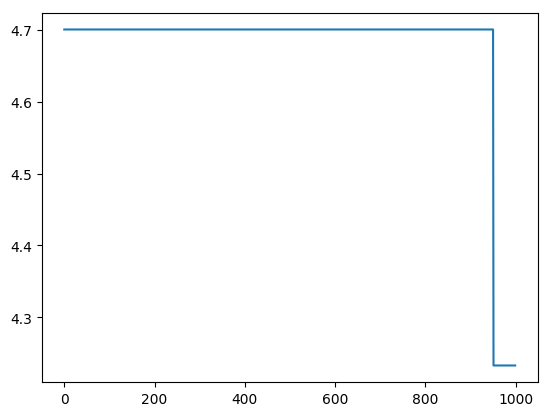

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f779cdc7e48>

In [4]:
plot(sort(output[:,1],rev=true))

In [5]:
using StatsBase
summarystats(output[:,1])

Summary Stats:
Length:         1000
Missing Count:  0
Mean:           4.677386
Minimum:        4.233155
1st Quartile:   4.700275
Median:         4.700275
3rd Quartile:   4.700275
Maximum:        4.700275


In [6]:
mean(output[:,1] .< mean(output[:,1]))

0.049

In [7]:
exp(4.233155-4.700275)

0.6268048693148833

In [11]:
function showsummary(x)
    support = reshape(x[(1:p*k).+1],p,k)
    weight = x[(1:k) .+ (p*k+1)]
    theta = x[(1:p2) .+ (p*k+k+1)]
    optimum = x[1]
    return [support, weight, theta, optimum]
end

function showplot(x)
    path = x[(1:niter) .+ (length(x)-niter)]
    return plot(1:niter, path, color="red", linewidth=2.0, linestyle="solid")
end

function showsummary2(x)
    theta = x[(1:p2).+1]
    optimum = x[1]
    return [theta, optimum]
end

function showplot2(x)
    path = x[(1:niter2) .+ (length(x)-niter2)]
    return plot(1:niter2, path, color="red", linewidth=2.0, linestyle="solid")
end

showplot2 (generic function with 1 method)

In [15]:
loc = findmin(output[:,1])[2]
showsummary2(output[loc,:])

2-element Array{Any,1}:
  [0.0, 3.0]      
 4.233154912731548